
# Problem Statement:

## Tomato plants are susceptible to various diseases, leading to significant economic losses in agriculture. Identifying and classifying these diseases in a timely manner is crucial for effective disease management. Traditional methods of disease diagnosis in tomato plants involve manual inspection, which is time-consuming and may not always be accurate. To address this issue, there is a need for a deep learning model that can automatically analyze images of tomato plants and accurately classify the type of disease present, along with providing a confidence level for each prediction. This would enable farmers to take prompt and targeted actions to mitigate the impact of diseases on their crops, ultimately improving crop yield and reducing economic losses.

### install this library

#### !pip install --upgrade pip
#### !pip install tensorflow


## dataset

### Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

# Tomato Disease Classification

## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

## Set all the Constants

In [2]:
BATCH_SIZE = 50
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

i am split data on 50 images one batch

## Import data into tensorflow dataset object

In [3]:
import os
import tensorflow as tf

directory_path = r"C:\Users\shreyash\Desktop\deep learning project\tomato-disease\PlantVillage"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,  # Use the correct directory path here
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 16011 files belonging to 10 classes.


they are 16000 images data and 10 different classes

In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

this is a 10 different classes

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(50, 256, 256, 3)
[0 1 5 4 7 5 5 9 5 1 9 7 7 7 0 6 0 9 3 2 9 9 7 4 7 4 1 6 5 2 0 2 1 7 7 7 6
 3 0 7 2 3 0 4 1 4 3 0 5 5]


As you can see above, each element in the dataset is a tuple. First element is a batch of 50 elements of images. Second element is a batch of 50 elements of class labels

## Visualize some of the images from our dataset

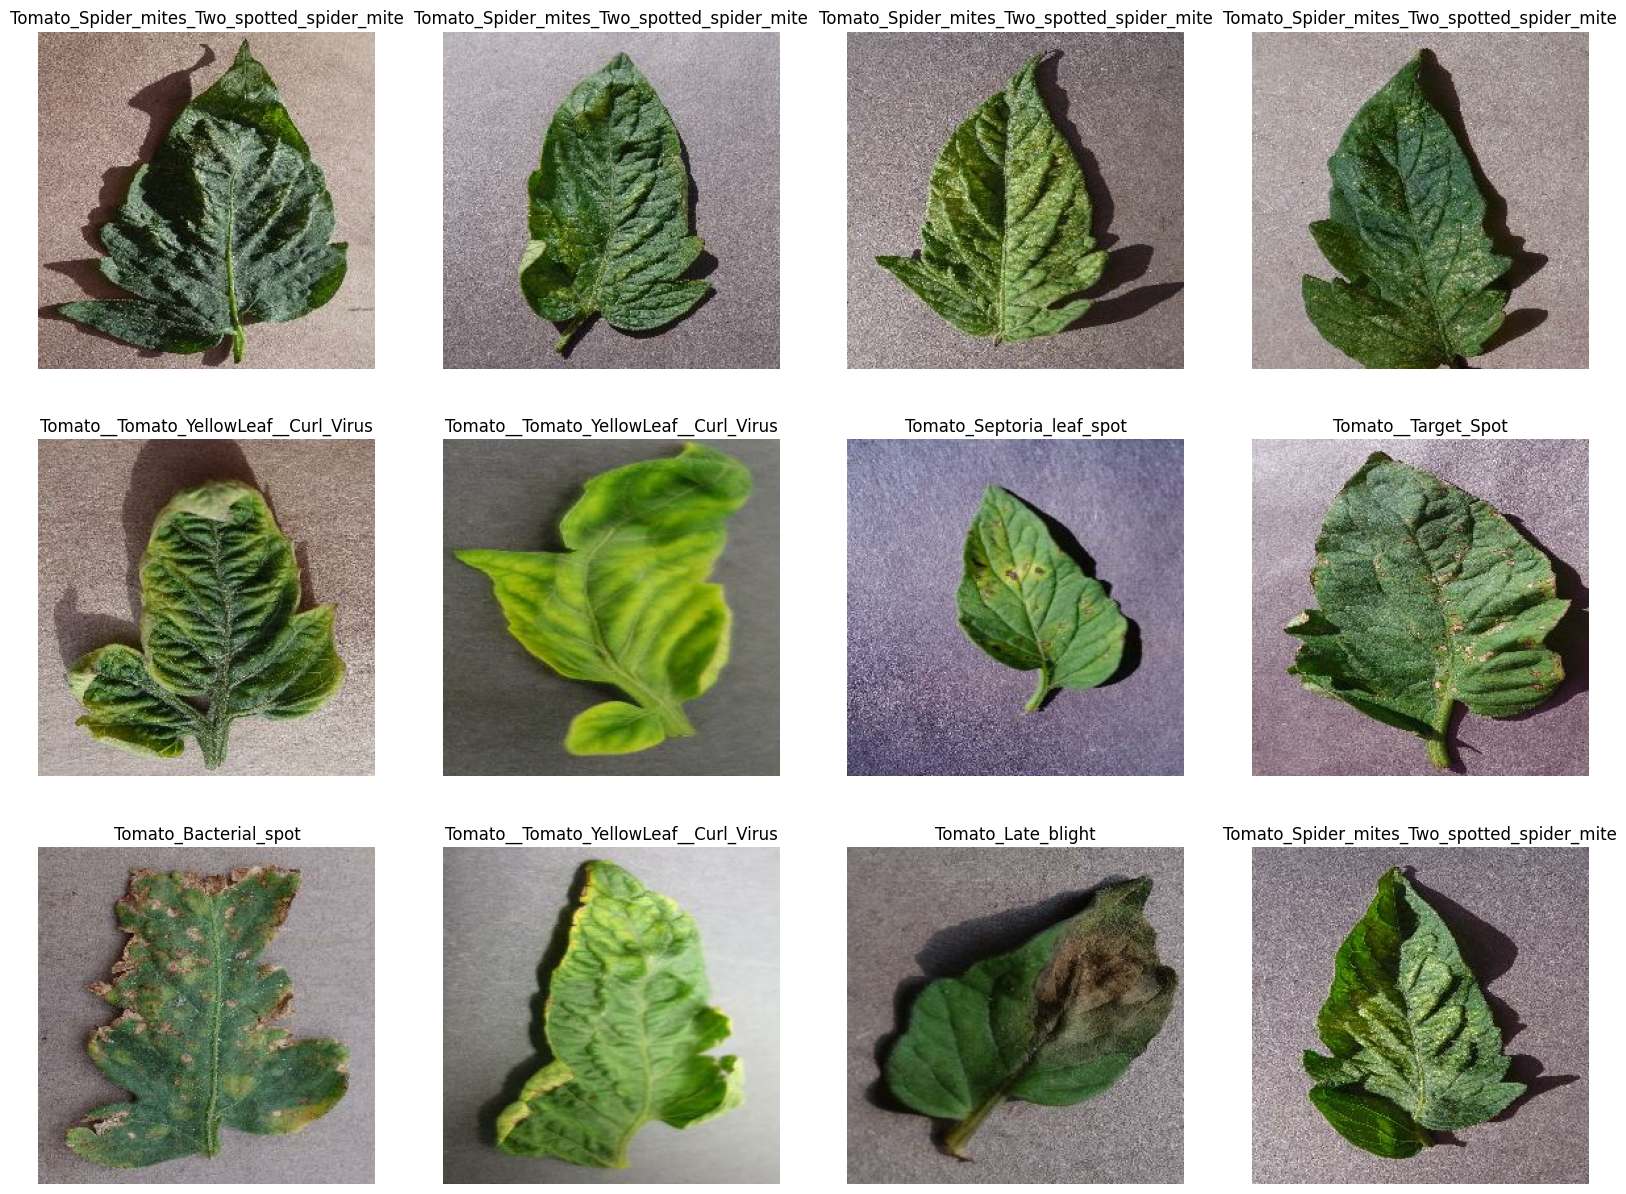

In [6]:
plt.figure(figsize=(20, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

this is different different images in one batch

## Function to Split Dataset

### Dataset should be bifurcated into 3 subsets, namely model

    1. Training: Dataset to be used while training

    2. Validation: Dataset to be tested against while training

    3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

321

the total size of dataset is 321 batch and each batch was 50 images

In [8]:
train_size = 0.8
len(dataset)*train_size

256.8

In [9]:
train_ds = dataset.take(256)
len(train_ds)

256

i am training 80% of data was 256 batch

In [10]:
test_ds = dataset.skip(256)
len(test_ds)

65

In [11]:
val_size=0.1
len(dataset)*val_size

32.1

In [12]:
val_ds = test_ds.take(32)
len(val_ds)

32

the 10% dataset was the validation and this is size is 32 batch 

In [13]:
test_ds = test_ds.skip(32)
len(test_ds)

33

the remaining 10% dataset was test dataset and size was 33 batch

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

256

In [17]:
len(val_ds)

32

In [18]:
len(test_ds)

33

## Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(3500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(3500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(3500).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (50, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (50, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (50, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (50, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (50, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (50, 60, 60, 64)         

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30


256/256 [==============================] - 294s 1000ms/step - loss: 1.6323 - accuracy: 0.4178 - val_loss: 1.1422 - val_accuracy: 0.5987
Epoch 2/30
256/256 [==============================] - 233s 906ms/step - loss: 0.9814 - accuracy: 0.6626 - val_loss: 1.0149 - val_accuracy: 0.6581
Epoch 3/30
256/256 [==============================] - 219s 854ms/step - loss: 0.7419 - accuracy: 0.7440 - val_loss: 0.9517 - val_accuracy: 0.7013
Epoch 4/30
256/256 [==============================] - 223s 870ms/step - loss: 0.6112 - accuracy: 0.7919 - val_loss: 0.9828 - val_accuracy: 0.7150
Epoch 5/30
256/256 [==============================] - 209s 814ms/step - loss: 0.5066 - accuracy: 0.8242 - val_loss: 0.8046 - val_accuracy: 0.7237
Epoch 6/30
256/256 [==============================] - 222s 865ms/step - loss: 0.4330 - accuracy: 0.8506 - val_loss: 0.4934 - val_accuracy: 0.8375
Epoch 7/30
256/256 [==============================] - 301s 1s/step - loss: 0.3789 - accuracy: 0.8675 - val_loss: 0.5234 -

In [27]:
scores = model.evaluate(test_ds)

33/33 [==============================] - 55s 253ms/step - loss: 0.1148 - accuracy: 0.9630


### You can see above that we get 96.30% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [28]:
scores

[0.11477704346179962, 0.9630302786827087]

Scores is just a list containing loss and accuracy value

## Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 256}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

30

In [34]:
history.history['loss'][:5]

[1.6323133707046509,
 0.9813539981842041,
 0.7419074773788452,
 0.6112372875213623,
 0.5065731406211853]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

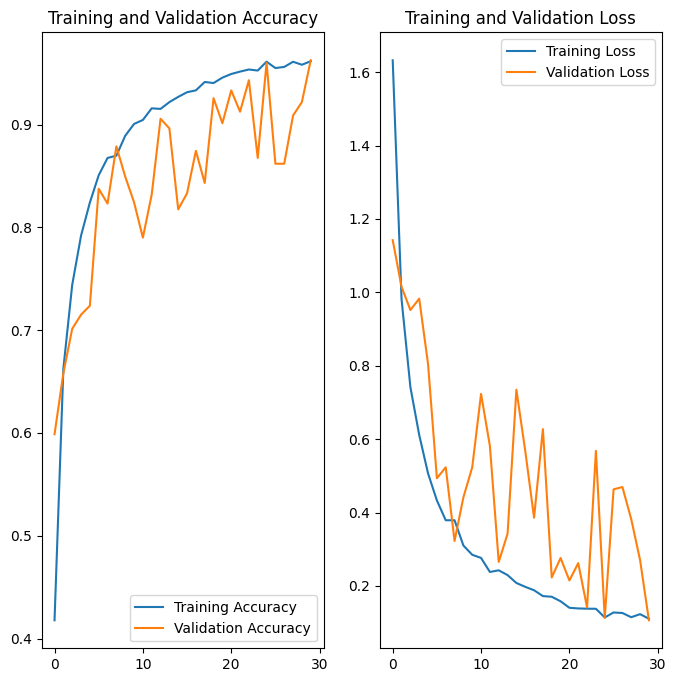

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image


first image to predict
actual label: Tomato_Early_blight
2/2 [==============================] - 1s 141ms/step
predicted label: Tomato_Early_blight


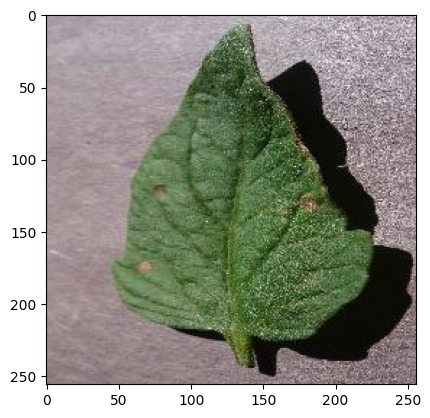

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 33ms/step


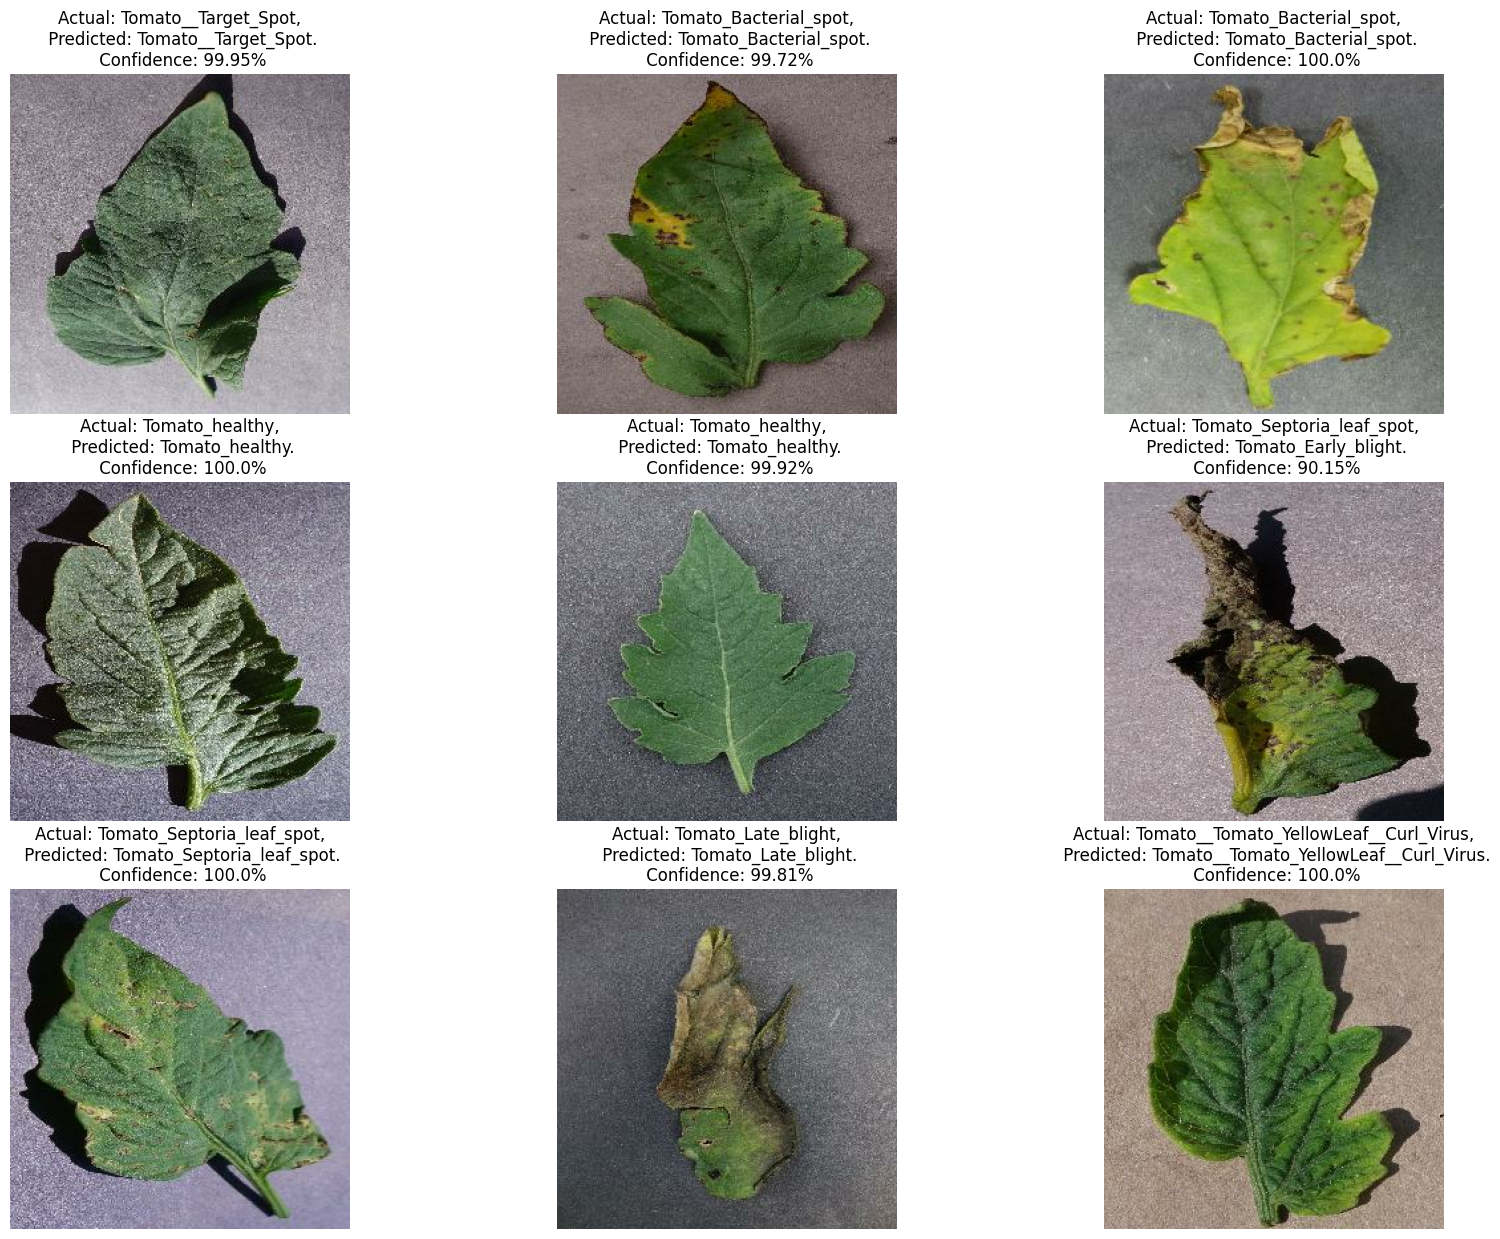

In [39]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model
 

### We append the model to the list of models as a new version

In [40]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [41]:
model.save("../Tomato.h5")

C:\Users\shreyash\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
